In [3]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import os
import seaborn as sns
#import cmocean as cmocn

%matplotlib inline

In [4]:
fname = '../generalStatistics/goodData_QSwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] **2 + ds['mean_U10N_y']**2)
data = ds.to_dataframe()

df = data.copy()

/tmp/ipykernel_3505043/1867474080.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_3505043/1867474080.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_3505043/1867474080.py:40: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/pytorch/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


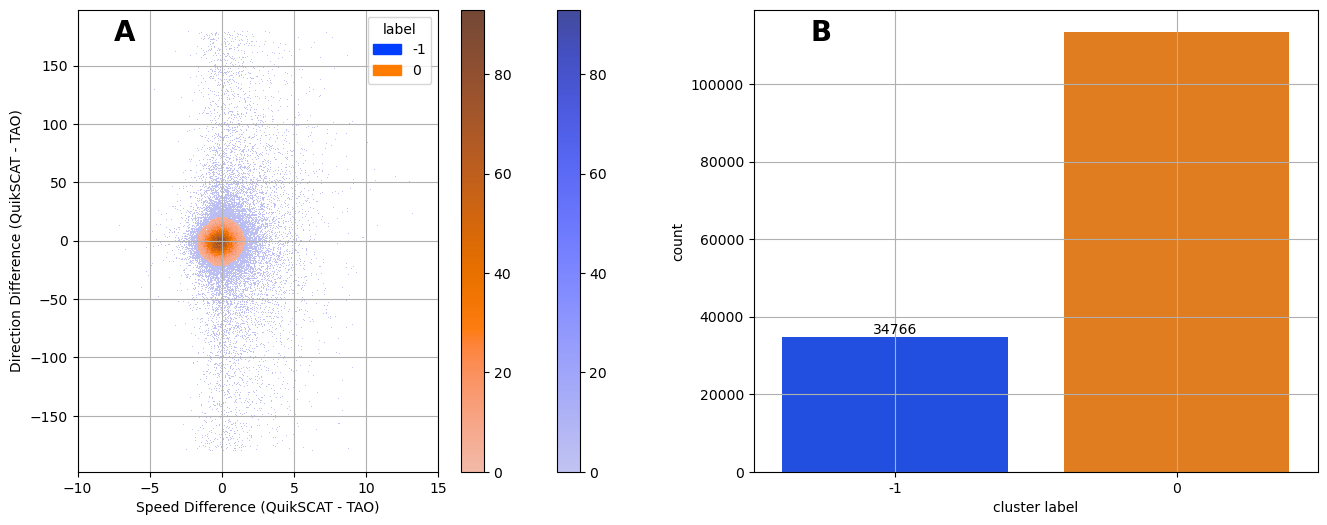

In [5]:
selectX = ['Speed Difference (QuikSCAT - TAO)',
          'cos(Direction Difference (QuikSCAT - TAO))',
          'sin(Direction Difference (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [6]:
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

subDF = df.copy()

subDF['norm_xlabel'] = 2 * (subDF[xlabel] - subDF[xlabel].min()) / (subDF[xlabel].max() - subDF[xlabel].min()) - 1
subDF['norm_ylabel'] = 2 * (subDF[ylabel] - subDF[ylabel].min()) / (subDF[ylabel].max() - subDF[ylabel].min()) - 1

subDF['norm_xlabel'] = (subDF['norm_xlabel'] - subDF['norm_xlabel'].mean() + 0.01) #/ (subDF['norm_xlabel'].std())
subDF['norm_ylabel'] = (subDF['norm_ylabel'] - subDF['norm_ylabel'].mean()) #/ (subDF['norm_ylabel'].std())

# subDF['norm_xlabel'] = (subDF[xlabel] - subDF[xlabel].mean()) / (subDF[xlabel].std())
# subDF['norm_ylabel'] = (subDF[ylabel] - subDF[ylabel].mean()) / (subDF[ylabel].std())

# subDF['norm_xlabel'] = 2 * (subDF['norm_xlabel'] - subDF['norm_xlabel'].min()) / (subDF['norm_xlabel'].max() - subDF['norm_xlabel'].min()) - 1
# subDF['norm_ylabel'] = 2 * (subDF['norm_ylabel'] - subDF['norm_ylabel'].min()) / (subDF['norm_ylabel'].max() - subDF['norm_ylabel'].min()) - 1

subDF['theta'] = np.rad2deg(np.arctan2(subDF['norm_ylabel'], subDF['norm_xlabel']))
subDF['r'] = np.sqrt(subDF['norm_ylabel']**2 + subDF['norm_xlabel']**2)

subDF['org_theta'] = np.rad2deg(np.arctan2(subDF[ylabel], subDF[xlabel]))
subDF['org_r'] = np.sqrt(subDF[ylabel]**2 + subDF[xlabel]**2)

# df['theta'] = np.rad2deg(np.arctan2(df[ylabel], df[xlabel]))
# df['r'] = np.sqrt(df[ylabel]**2 + df[xlabel]**2)

# Define bin edges using NumPy (0 to 360 in 0.25° steps)
num_bins = 360*6
bin_edges = np.linspace(0, 360, num_bins, endpoint = False)  # 1441 edges for 1440 bins
right_edges = np.roll(bin_edges, -1)
right_edges[-1] = 360
bin_centers = (bin_edges + right_edges)/2
# Digitize theta into bins
subDF['org_theta_bin'] = np.digitize((subDF['org_theta'] + 360)% 360, bins=bin_edges, right=False)
subDF['org_theta_bin'] = subDF['org_theta_bin'] % num_bins  # Ensure cyclic wrap-around


subDF['theta_bin'] = np.digitize((subDF['theta'] +360) % 360, bins=bin_edges, right=False)
subDF['theta_bin'] = subDF['theta_bin'] % num_bins  # Ensure cyclic wrap-around

ssubDF = subDF.loc[df['label'] == 0]

In [7]:
bin_centers

array([8.33333333e-02, 2.50000000e-01, 4.16666667e-01, ...,
       3.59583333e+02, 3.59750000e+02, 3.59916667e+02], shape=(2160,))

In [8]:
np.max(subDF['org_theta_bin'])

np.int64(2159)

In [9]:
maxr = []
minr = []
for i in range(num_bins):
    thisDF = ssubDF.loc[ssubDF['org_theta_bin'] == i]
    maxr.append(np.max(thisDF['org_r']))
    minr.append(np.min(thisDF['org_r']))

[]

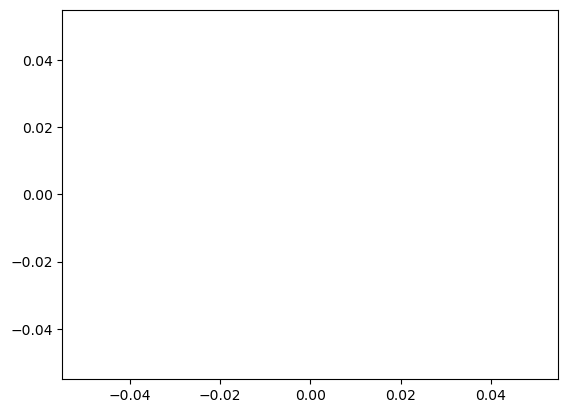

In [10]:
maxr = np.array(maxr)

plt.plot()

In [11]:
def isInsideEllipse(x, y, a, b, x1, y1):
    LHS = ((x - x1)**2)/a**2 + ((y-y1)**2)/b**2
    labels = np.array(LHS < 1, dtype=int)
    return labels

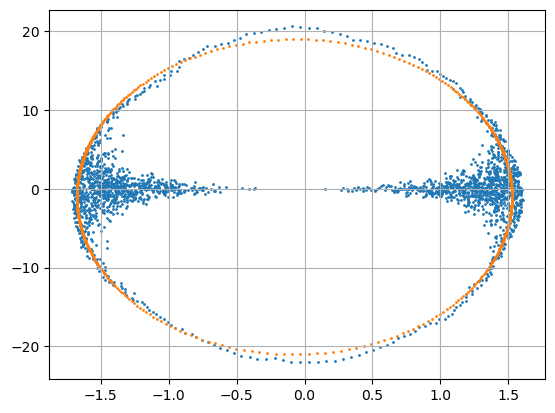

In [12]:
a = 1.6
b = 20
x1 = -0.075
y1 = -1

A = b**2 * np.cos(np.deg2rad(bin_centers))**2 +  a**2 * np.sin(np.deg2rad(bin_centers))**2
B = -2 * (x1 * np.cos(np.deg2rad(bin_centers)) * b**2 + y1 * np.sin(np.deg2rad(bin_centers)) * a**2 )  
C = x1**2* b**2 + y1**2 * a**2 - a**2 * b**2

r1 = (-B + np.sqrt(B**2 - 4* A * C))/(2* A)
#r2 = (-B - np.sqrt(B**2 - 4* A * C))/(2* A)

r = np.sqrt(a **2 * b**2 /(a**2 * np.sin(np.deg2rad(bin_centers))**2 + b**2 * np.cos(np.deg2rad(bin_centers))**2))
plt.scatter(maxr * np.cos(np.deg2rad(bin_centers)), maxr * np.sin(np.deg2rad(bin_centers)), s = 1)
#plt.scatter(r2 * np.cos(np.deg2rad(bin_centers)), r2 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.scatter(r1 * np.cos(np.deg2rad(bin_centers)), r1 * np.sin(np.deg2rad(bin_centers)), s = 1)
plt.grid()

In [13]:
ellipseLabel = isInsideEllipse(df[xlabel].to_numpy(), df[ylabel].to_numpy(), a, b, x1, y1)
subDF['ellipseLabel'] = ellipseLabel

/tmp/ipykernel_3505043/667613468.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_3505043/667613468.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_3505043/667613468.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/pytorch/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


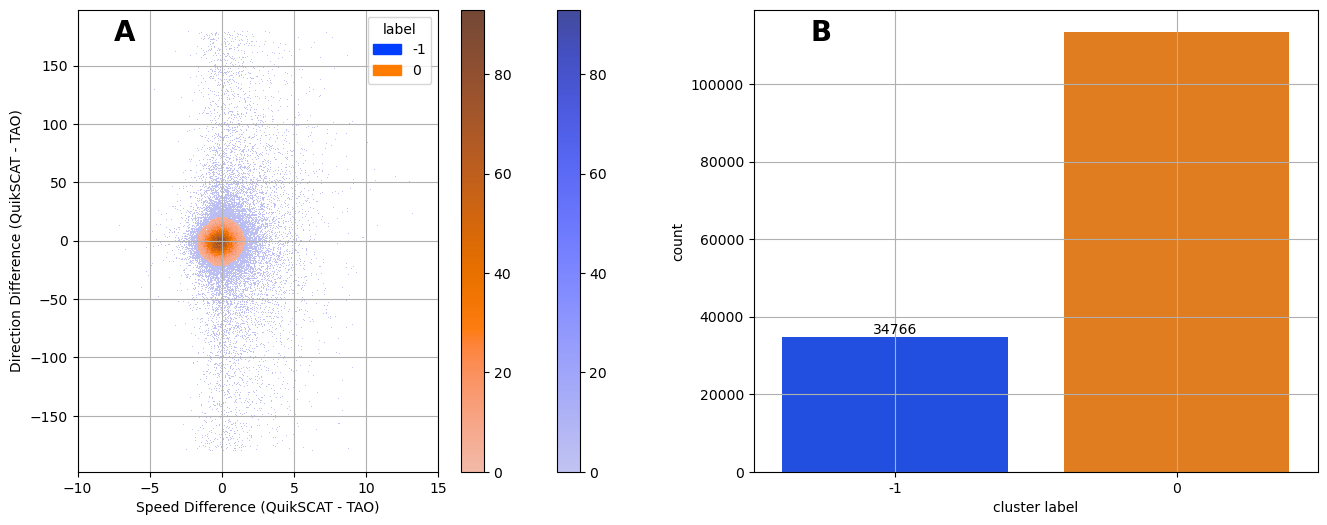

In [14]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


/tmp/ipykernel_3505043/3754269681.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_3505043/3754269681.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_3505043/3754269681.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/pytorch/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


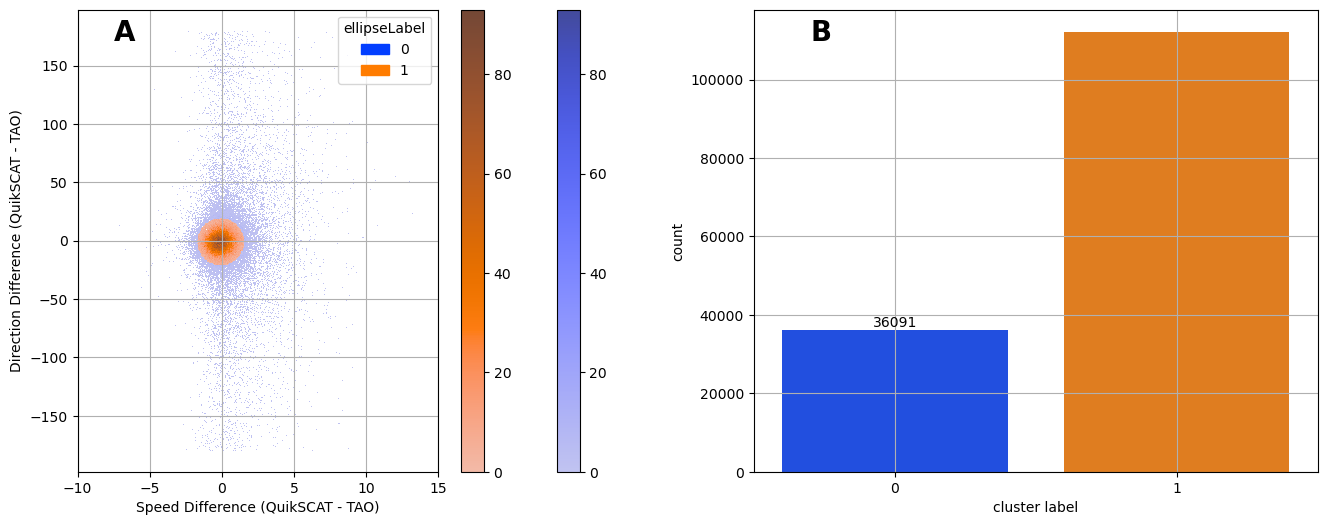

In [15]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(subDF, x=xlabel, y = ylabel,#levels=10, 
                hue='ellipseLabel', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(subDF, x='ellipseLabel',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


In [16]:
print(np.min(subDF['norm_xlabel']), np.max(subDF['norm_xlabel']))
print(np.min(subDF['norm_ylabel']), np.max(subDF['norm_ylabel']))
print(np.min(ssubDF['r']), np.max(ssubDF['r']))
print(np.min(subDF['r']), np.max(subDF['r']))

-0.6160218414343746 1.3839781585656254
-0.9982810103075032 1.001718989692497
0.00011599063287677908 0.13954560704314503
0.00011599063287677908 1.5756402999746013


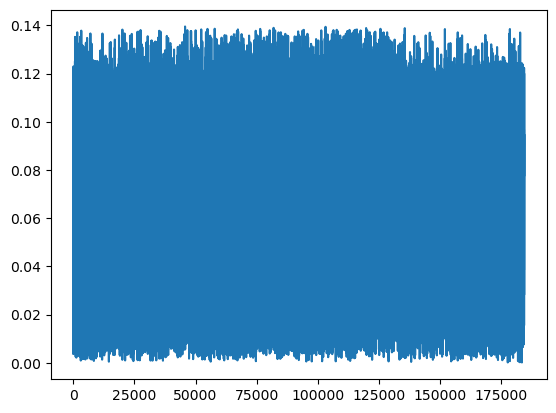

In [17]:
plt.plot(ssubDF['r'])

In [18]:
ssubDF = subDF.loc[np.logical_and(subDF['r'].to_numpy() > 0.11, subDF['r'].to_numpy() < 0.16)]

/tmp/ipykernel_3505043/2357187042.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(ssubDF, x=xlabel, y = ylabel, #levels=10,
/tmp/ipykernel_3505043/2357187042.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)
/tmp/ipykernel_3505043/2357187042.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

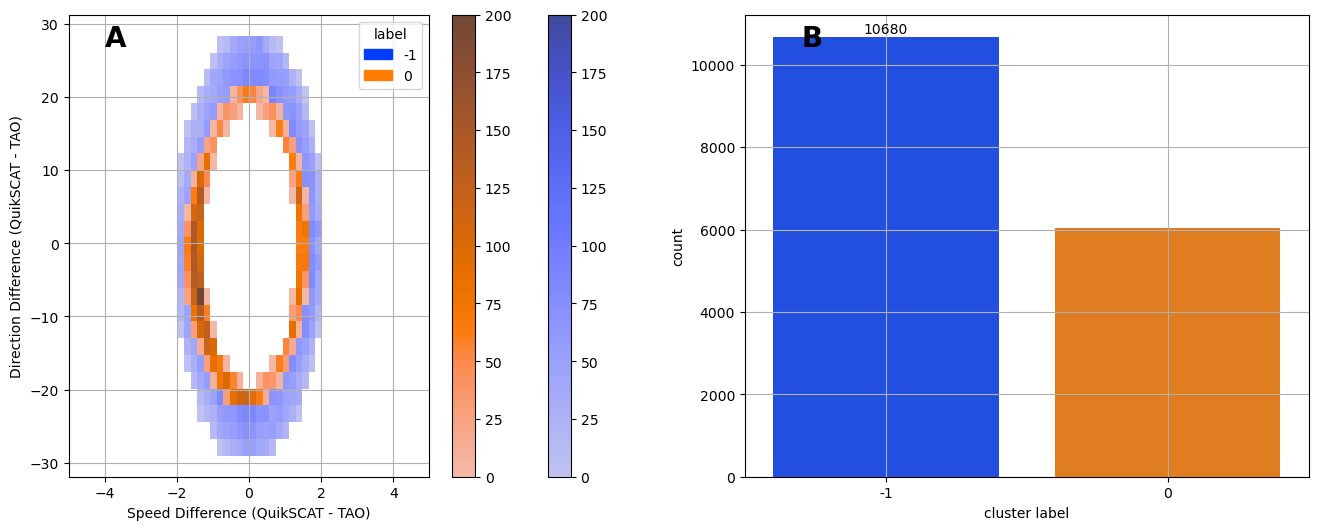

In [19]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(ssubDF, x=xlabel, y = ylabel, #levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-5,5)

ax = axes[1]
s = sns.countplot(ssubDF, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [20]:
mask = np.logical_and(subDF['r'].to_numpy() > 0.09, subDF['r'].to_numpy() < 0.17)
subDF = subDF.loc[~mask]

In [21]:
subDF['SST-AIRT'] = subDF['Sea Surface Temperature (TAO)'] - subDF['Air Temperature (TAO)']

In [22]:
list(subDF.keys())

['Wind Direction (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'Wind Speed (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'Zonal Wind Speed (TAO)',
 'Meridional Wind Speed (TAO)',
 'Sea Surface Temperature (TAO)',
 'SST_QC',
 'SST_DM',
 'Relative Humidity (TAO)',
 'RELH_QC',
 'RELH_DM',
 'Air Temperature (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'Neutral Wind Speed at 10m (TAO)',
 'Wind Speed at 10m (TAO)',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_RELH',
 'std_RELH',
 'mean_U10N_x',
 'std_U10N_x',
 'mean_U10N_y',
 'std_U10N_y',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'LATITUDE',
 'LONGITUDE',
 'TAO_TIME',
 'Deployment index',
 'Wind Speed (QuikSCAT)',
 'Wind Direction (QuikSCAT)',
 'rain_impact',
 'flags',
 'eflags',
 'nudge_wind_speed',
 'nudge_wind_direction',
 'retrieved_wind_speed_uncorrected',
 'cross_track_wind_speed_bias',
 'atmospheric_speed_bias',
 'wind_obj',
 'ambigu

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np

# ---- Data Preparation ----
subDF['label'] = subDF['label'].apply(lambda x: 1 if x == 0 else 0)

features = ['std_cosWDIR', 'std_sinWDIR', 'SST-AIRT', 'mean_SST - AIRT', 'std_SST - AIRT', 
             'Relative Humidity (TAO)', 'mean_RELH', 'mean_SST', 'std_AIRT', 'std_SST', 
             'mean_AIRT', 'std_RELH', 'Neutral Wind Speed at 10m (TAO)', 
             'std_WSPD', 'mean_WSPD', 'mean_WSPD_10N', 'std_WSPD_10N']

X = subDF[features].values
y = subDF['ellipseLabel'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for balancing
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ---- Define the Neural Network ----
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(X_train_bal.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Training Loop with Early Stopping ----
best_loss = np.inf
patience = 10
trigger_times = 0

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/100], Loss: {epoch_loss:.4f}")
    
    # Early Stopping Check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# ---- Evaluation ----
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ModuleNotFoundError: No module named 'torch'

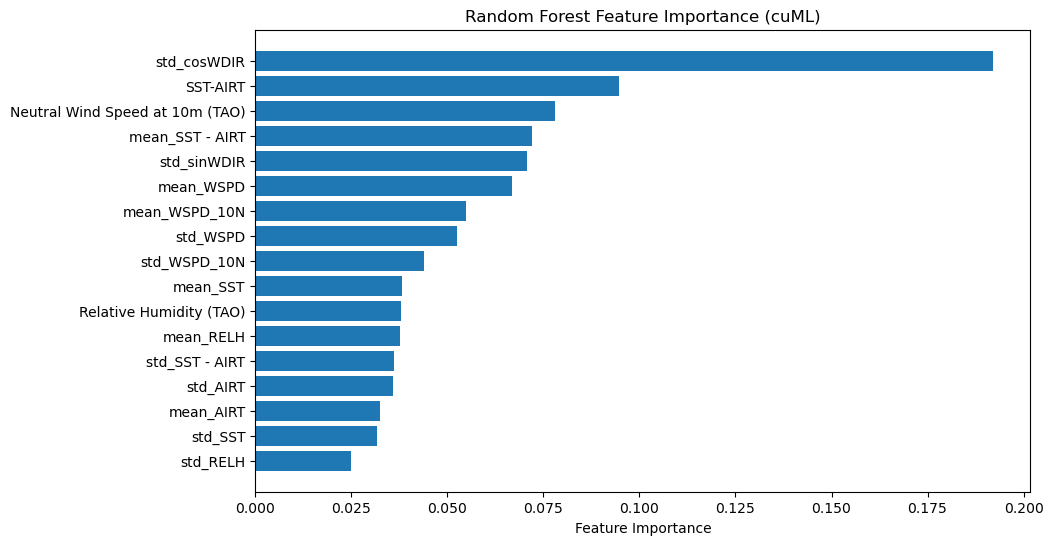

In [23]:
#importances = best_model.feature_importances_
importances = classifier.feature_importances_

# Feature names (must match your input order)
feature_names = X_train.columns  

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (cuML)')
plt.gca().invert_yaxis()  # Most important at top

In [24]:
import joblib

joblib.dump(classifier, "random_forest_goodBadMatchup.joblib")

# # load
# loaded_rf = joblib.load("my_random_forest.joblib")

['random_forest_goodBadMatchup.joblib']

/tmp/ipykernel_3326980/4268395156.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df.loc[df['label'] == -1], x=xlabel, y = ylabel, bins=1000,


(-3.0, 3.0)

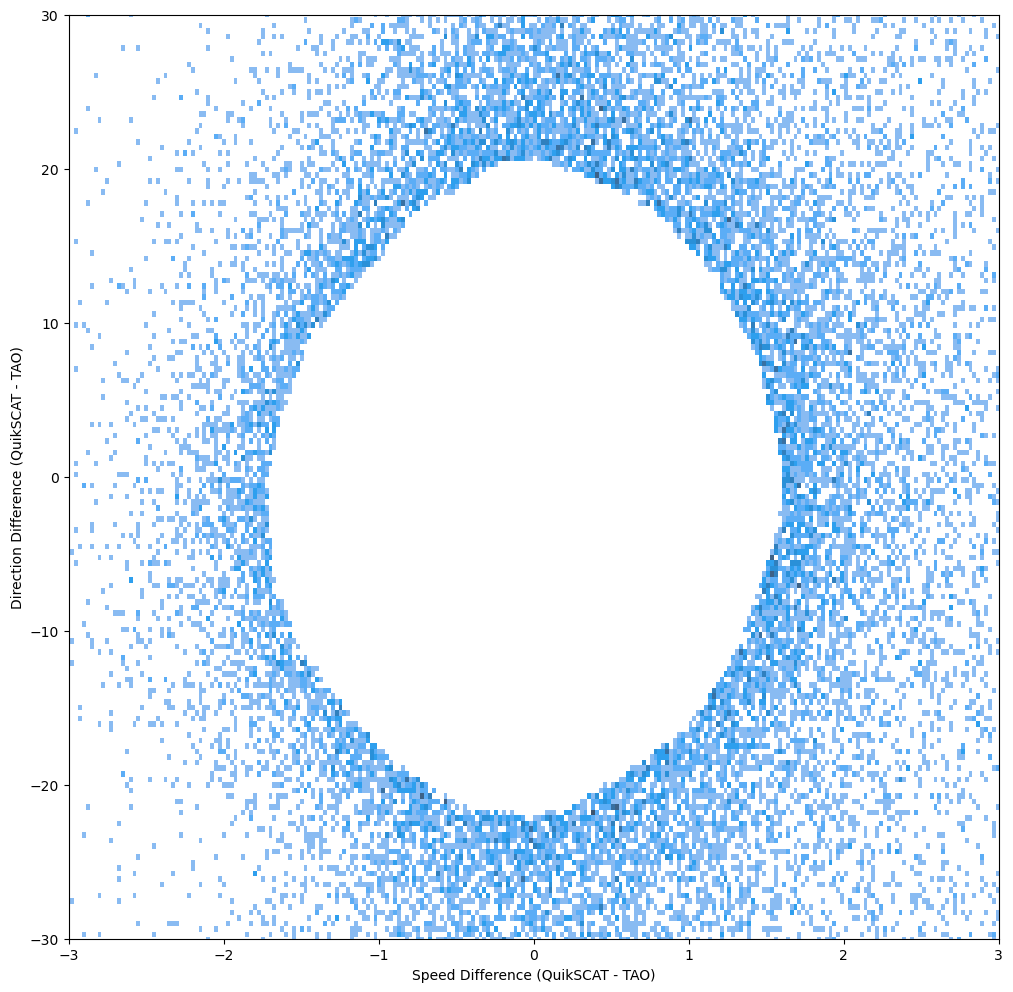

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
sns.histplot(df.loc[df['label'] == -1], x=xlabel, y = ylabel, bins=1000, 
            #hue='label', common_norm=True, cbar = True,
            palette = sns.color_palette("bright"), ax = ax)
ax.set_ylim([-30,30])
ax.set_xlim([-3,3])

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Label Transformation
subDF['label'] = subDF['label'].apply(lambda x: 1 if x == 0 else 0)

# Features and Target
features = ['std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'mean_SST - AIRT',
            'std_SST - AIRT', 
            'Relative Humidity (TAO)',             
            'mean_RELH',             
            'mean_SST',
            'std_AIRT',
            'std_SST', 
            'mean_AIRT',
            'std_RELH',
            'Neutral Wind Speed at 10m (TAO)',
            'std_WSPD', 
            'mean_WSPD',
            'mean_WSPD_10N',
            'std_WSPD_10N']

X = subDF[features].values
y = subDF['ellipseLabel'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE for Class Balancing
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

# Build the Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to Prevent Overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history = model.fit(X_train_bal, y_train_bal, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stop],
                    verbose=1)

plot_training_curves(history)

# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


2025-05-12 10:11:37.878640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 10:11:38.261602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


/home/shikhar.rai/anaconda3/envs/tfXarr/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3753/3753 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8499 - loss: 0.3717 - val_accuracy: 0.7824 - val_loss: 0.4753
Epoch 2/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8629 - loss: 0.3404 - val_accuracy: 0.7824 - val_loss: 0.5167
Epoch 3/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8636 - loss: 0.3373 - val_accuracy: 0.8002 - val_loss: 0.4951
Epoch 4/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8637 - loss: 0.3345 - val_accuracy: 0.8179 - val_loss: 0.4449
Epoch 5/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8673 - loss: 0.3270 - val_accuracy: 0.8133 - val_loss: 0.4429
Epoch 6/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8664 - loss: 0.3271 - val_accuracy: 0.7931 - val_loss: 0.5213
Epoch 7/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8687 - loss: 0.3245 - val_accuracy: 0.8002 - val_loss: 0.4778
Epoch 8/100
3753/3753 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8690 - loss: 0.323

NameError: name 'plot_training_curves' is not defined

In [27]:
# Predictions
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print("Training Accuracy (Last Epoch):", history.history['accuracy'][-1])
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

726/726 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training Accuracy (Last Epoch): 0.873035728931427

Test Accuracy: 0.8858779941409616

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.82      0.74      4554
           1       0.95      0.90      0.93     18658

    accuracy                           0.89     23212
   macro avg       0.81      0.86      0.83     23212
weighted avg       0.90      0.89      0.89     23212



In [29]:
import keras_tuner as kt  # If you're using Keras Tuner v1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_dim = X_train_bal.shape[1]

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', 16, 128, step=16), activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i}', 16, 128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='wind_matchup_tuning'
)

tuner.search(X_train_bal, y_train_bal,
             validation_split=0.2,
             epochs=50,
             batch_size=32,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get best model
best_model = tuner.get_best_models(1)[0]
best_model.evaluate(X_test, y_test)


ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the full summary of trials as a DataFrame
tuner_results = tuner.oracle.get_best_trials(num_trials=10)
results_data = []

for trial in tuner_results:
    trial_summary = trial.metrics.get_last_value('val_accuracy')
    trial_params = trial.hyperparameters.values
    trial_params['val_accuracy'] = trial_summary
    results_data.append(trial_params)

results_df = pd.DataFrame(results_data)

# Plot Validation Accuracy vs. Number of Neurons in Input Layer
plt.figure(figsize=(8, 5))
plt.scatter(results_df['units_input'], results_df['val_accuracy'], c='blue')
plt.xlabel('Neurons in Input Layer')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Input Layer Size')
plt.grid(True)
plt.show()

# Plot Validation Accuracy vs. Learning Rate
plt.figure(figsize=(8, 5))
plt.scatter(results_df['lr'], results_df['val_accuracy'], c='green')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()

# If you want to explore the DataFrame directly
print(results_df.sort_values(by='val_accuracy', ascending=False))
